In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  PrecisionRecallDisplay
from sklearn.metrics import recall_score
from collections import Counter
from sklearn.metrics import f1_score

from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.decomposition import PCA

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [115]:
feature_set =  'feature_set_6_normalised'
X_train = pd.read_csv( F'../data/{feature_set}/X_train_full.csv').drop(columns=['TX_ID','Time_of_day','CUSTOMER_ID','TERMINAL_ID'])
y_train = pd.read_csv( F'../data/{feature_set}/y_train.csv').values.ravel()

X_val = pd.read_csv( F'../data/{feature_set}/X_valid_full.csv').drop(columns=['TX_ID','Time_of_day','CUSTOMER_ID','TERMINAL_ID'])
y_val = pd.read_csv( F'../data/{feature_set}/y_valid.csv').values.ravel()

In [85]:
counter = Counter(y_train)
print("Number transactions within each of the classes: {}".format(counter))

pos = Counter(y_train).get(1)
neg = Counter(y_train).get(0)
total = neg+pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Number transactions within each of the classes: Counter({0.0: 727052, 1.0: 19456})
Weight for class 0: 0.51
Weight for class 1: 19.18


In [117]:
xgboost = XGBClassifier(n_estimators = 500,random_state=0,n_jobs=-1,class_weight = class_weight)
eval_set = [(X_val, y_val)]
xgboost.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, early_stopping_rounds=50, verbose=True)

[0]	validation_0-auc:0.86931
[1]	validation_0-auc:0.86967
[2]	validation_0-auc:0.86978
[3]	validation_0-auc:0.87028
[4]	validation_0-auc:0.87078
[5]	validation_0-auc:0.87080
[6]	validation_0-auc:0.87142
[7]	validation_0-auc:0.87137
[8]	validation_0-auc:0.87442
[9]	validation_0-auc:0.87456
[10]	validation_0-auc:0.87477
[11]	validation_0-auc:0.87770
[12]	validation_0-auc:0.87872
[13]	validation_0-auc:0.87874
[14]	validation_0-auc:0.88009
[15]	validation_0-auc:0.88039
[16]	validation_0-auc:0.88263
[17]	validation_0-auc:0.88284
[18]	validation_0-auc:0.88428
[19]	validation_0-auc:0.88477
[20]	validation_0-auc:0.88569
[21]	validation_0-auc:0.88573
[22]	validation_0-auc:0.88574
[23]	validation_0-auc:0.88553
[24]	validation_0-auc:0.88568
[25]	validation_0-auc:0.88568
[26]	validation_0-auc:0.88588
[27]	validation_0-auc:0.88598
[28]	validation_0-auc:0.88622
[29]	validation_0-auc:0.88641
[30]	validation_0-auc:0.88610
[31]	validation_0-auc:0.88608
[32]	validation_0-auc:0.88618
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=0, ...)

### Feature Importance

### Permutation Importance

In [9]:
perm = PermutationImportance(xgboost, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.2712 ± 0.0014,C_ID_AVG_AMOUNT_30
0.1701 ± 0.0010,C_ID_AVG_AMOUNT_1
0.1108 ± 0.0009,TRANSACTION_GOODS_AND_SERVICES_AMOUNT
0.0158 ± 0.0001,TERMINAL_ID_RISK_30DAY_WINDOW
0.0133 ± 0.0003,TX_AMOUNT
0.0085 ± 0.0001,C_ID_NB_TX_1
0.0011 ± 0.0002,C_ID_NB_TX_30
0.0009 ± 0.0001,C_ID_AVG_AMOUNT_7
0.0003 ± 0.0001,TERMINAL_ID_NB_TX_30DAY_WINDOW
0.0002 ± 0.0000,C_ID_NB_TX_7


### Partial Dependency plots

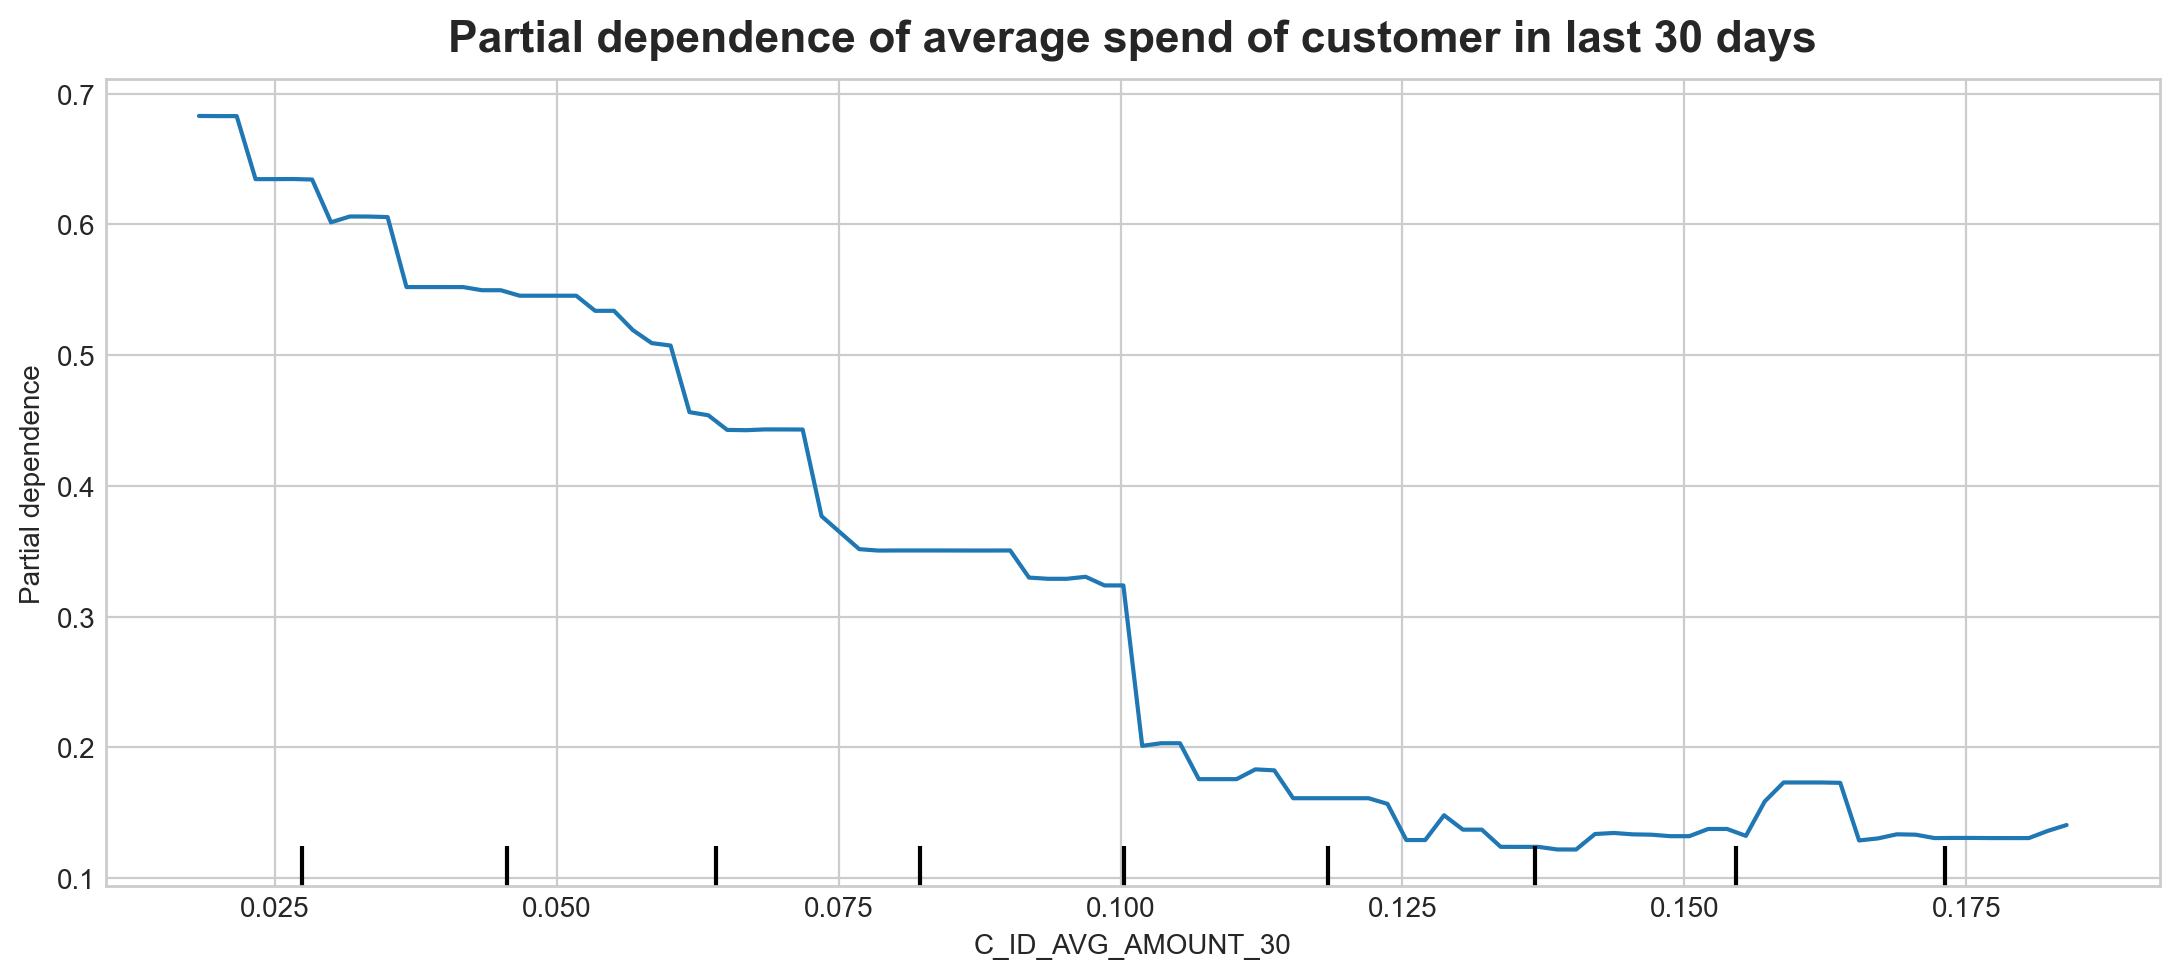

In [77]:
disp1 = PartialDependenceDisplay.from_estimator(xgboost, X_val, ['C_ID_AVG_AMOUNT_30'])
plt.title(F'Partial dependence of average spending of customer in last 30 days')
plt.show()

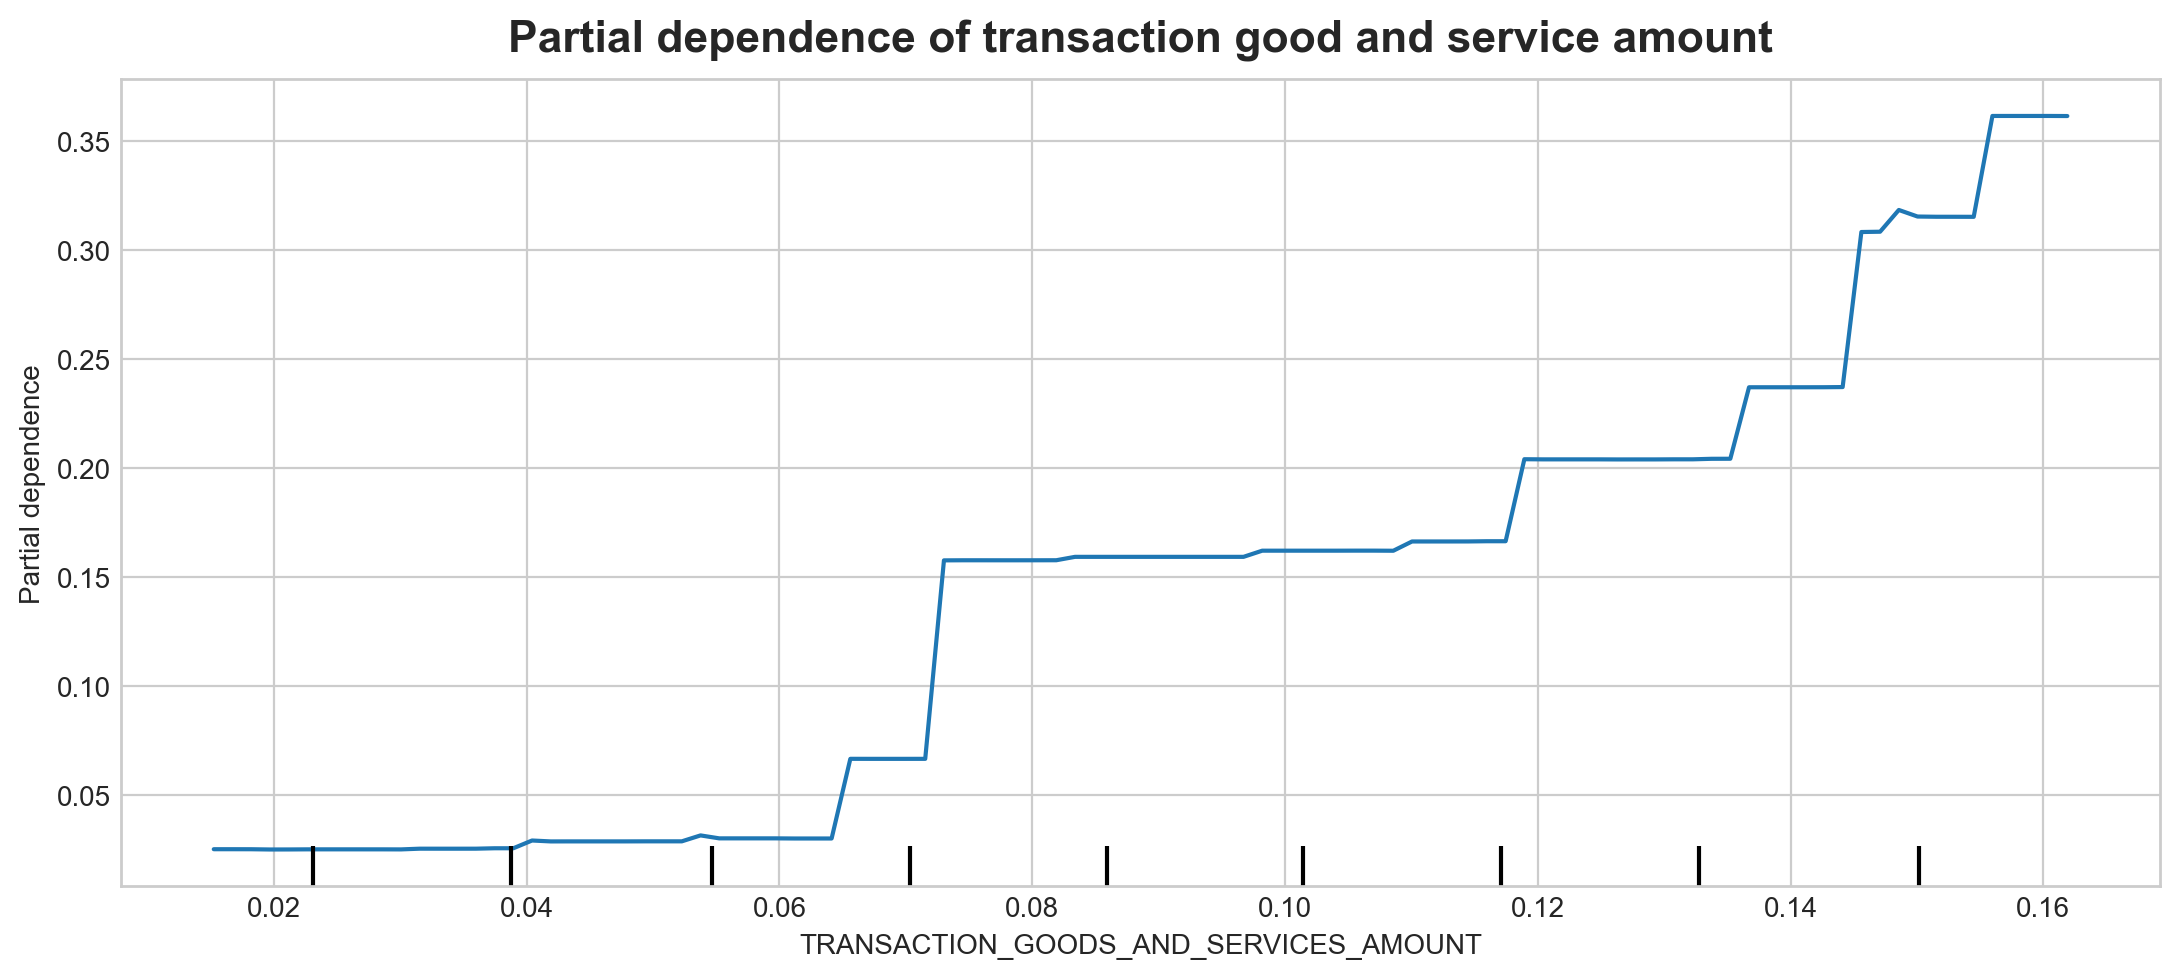

In [79]:
disp1 = PartialDependenceDisplay.from_estimator(xgboost, X_val, ['TRANSACTION_GOODS_AND_SERVICES_AMOUNT'])
plt.title(F'Partial dependence of transaction good and service amount')
plt.show()

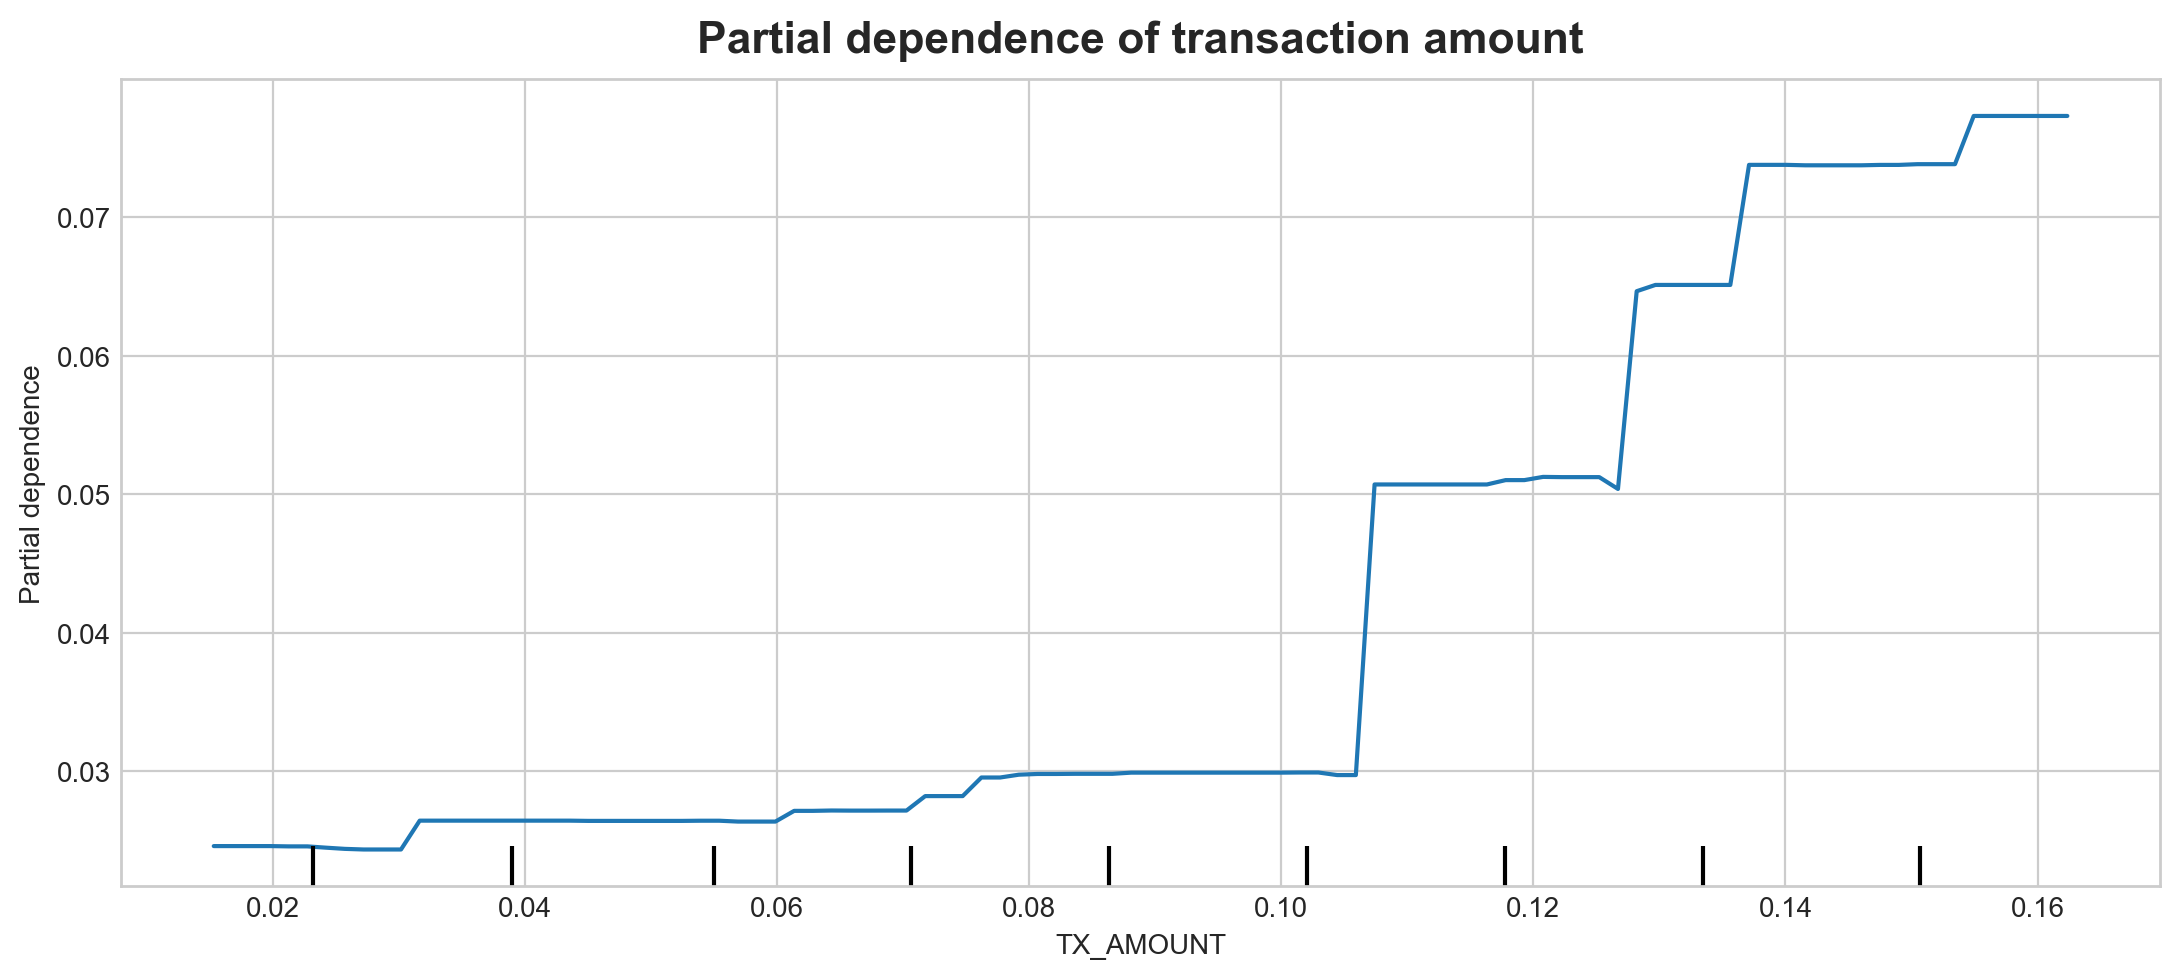

In [78]:
disp1 = PartialDependenceDisplay.from_estimator(xgboost, X_val, ['TX_AMOUNT'])
plt.title(F'Partial dependence of transaction amount')
plt.show()

## Shap Values

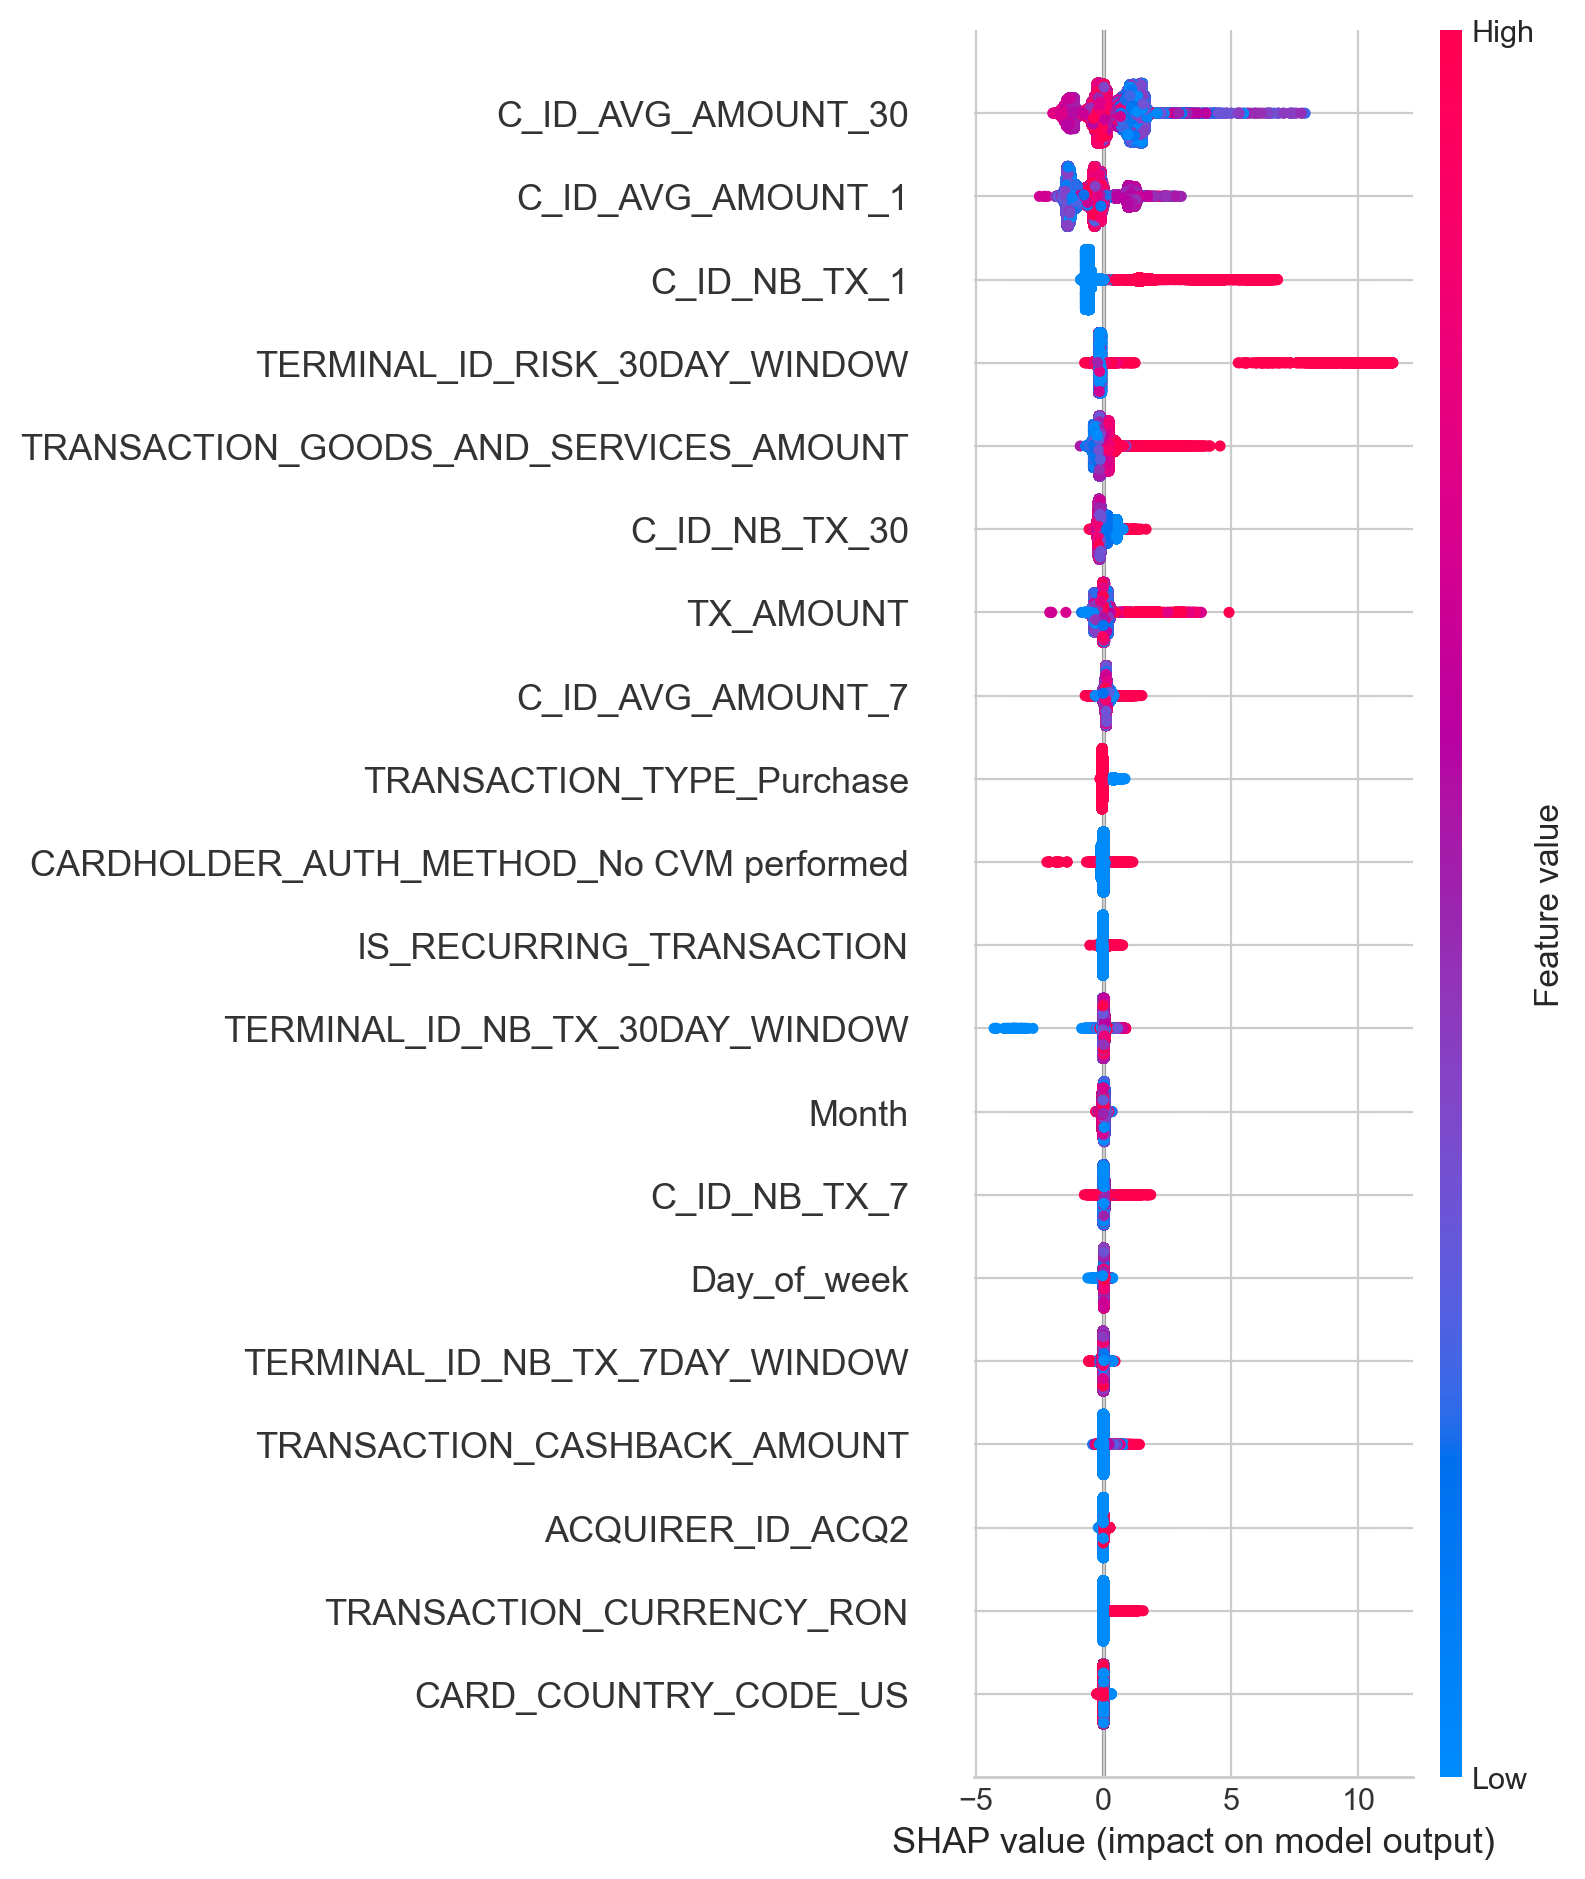

In [75]:
explainer = shap.TreeExplainer(xgboost)
shap.initjs()

shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values,X_val)

## Metrics

In [118]:

val_res = 1 -xgboost.predict_proba(X_val)[:,0]
print(F'The ROC AUC score on the validation set {roc_auc_score(y_val,val_res)}')


The ROC AUC score on the validation set 0.886669877727947


In [119]:
pred_boundary = []
for pred in val_res:
    if pred < 0.5:
        pred_boundary.append(0)
    else:
        pred_boundary.append(1)

In [120]:
print(F'The recall score on the validation set {recall_score(y_val, pred_boundary)}')


The recall score on the validation set 0.5023433645781944


In [121]:
print(F'The F1 score on the validation set {f1_score(y_val,pred_boundary)}')


The F1 score on the validation set 0.6449212255561714


In [109]:
cf_matrix = confusion_matrix(y_val, pred_boundary)
print(cf_matrix)

[[311066    758]
 [  3804   4304]]


<Axes: >

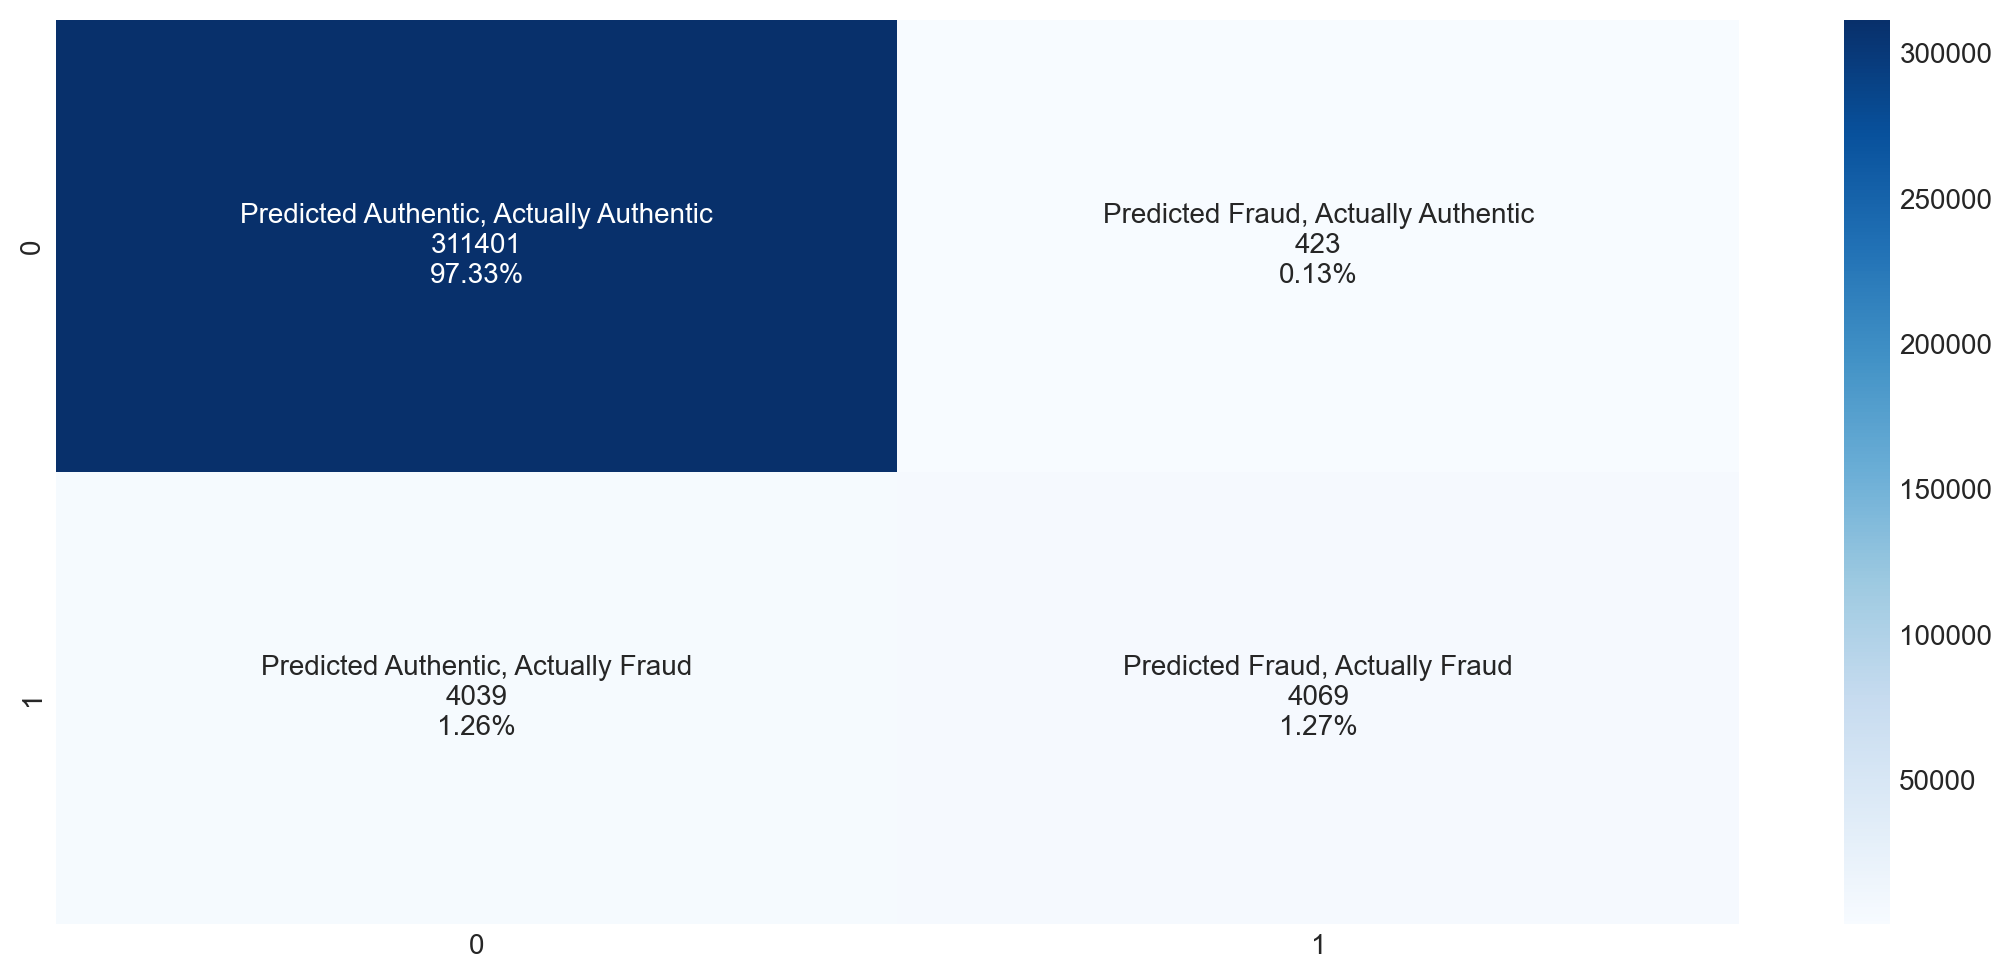

In [18]:
group_names = ['Predicted Authentic, Actually Authentic','Predicted Fraud, Actually Authentic','Predicted Authentic, Actually Fraud','Predicted Fraud, Actually Fraud']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

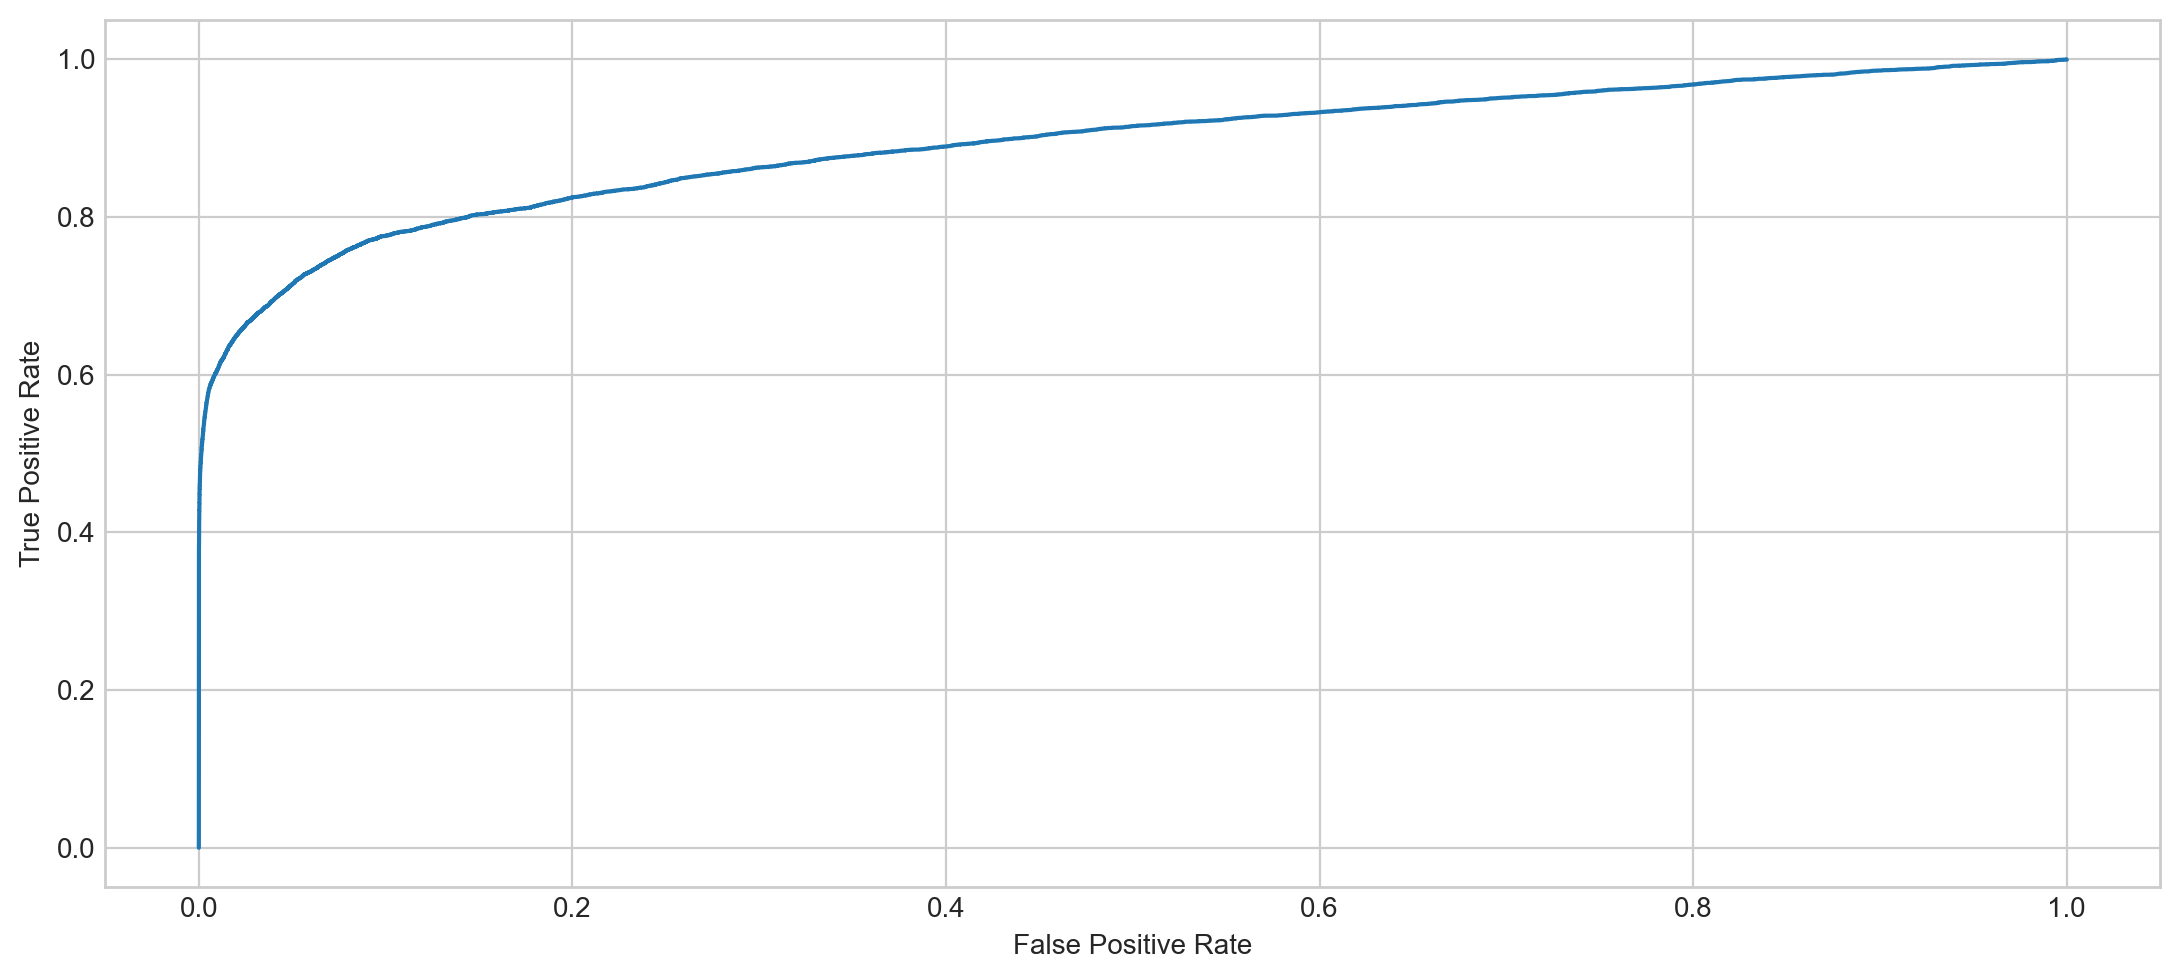

In [19]:
# y_score = xgboost.decision_function(X_val)

fpr, tpr, _ = roc_curve(y_val,val_res, pos_label=xgboost.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

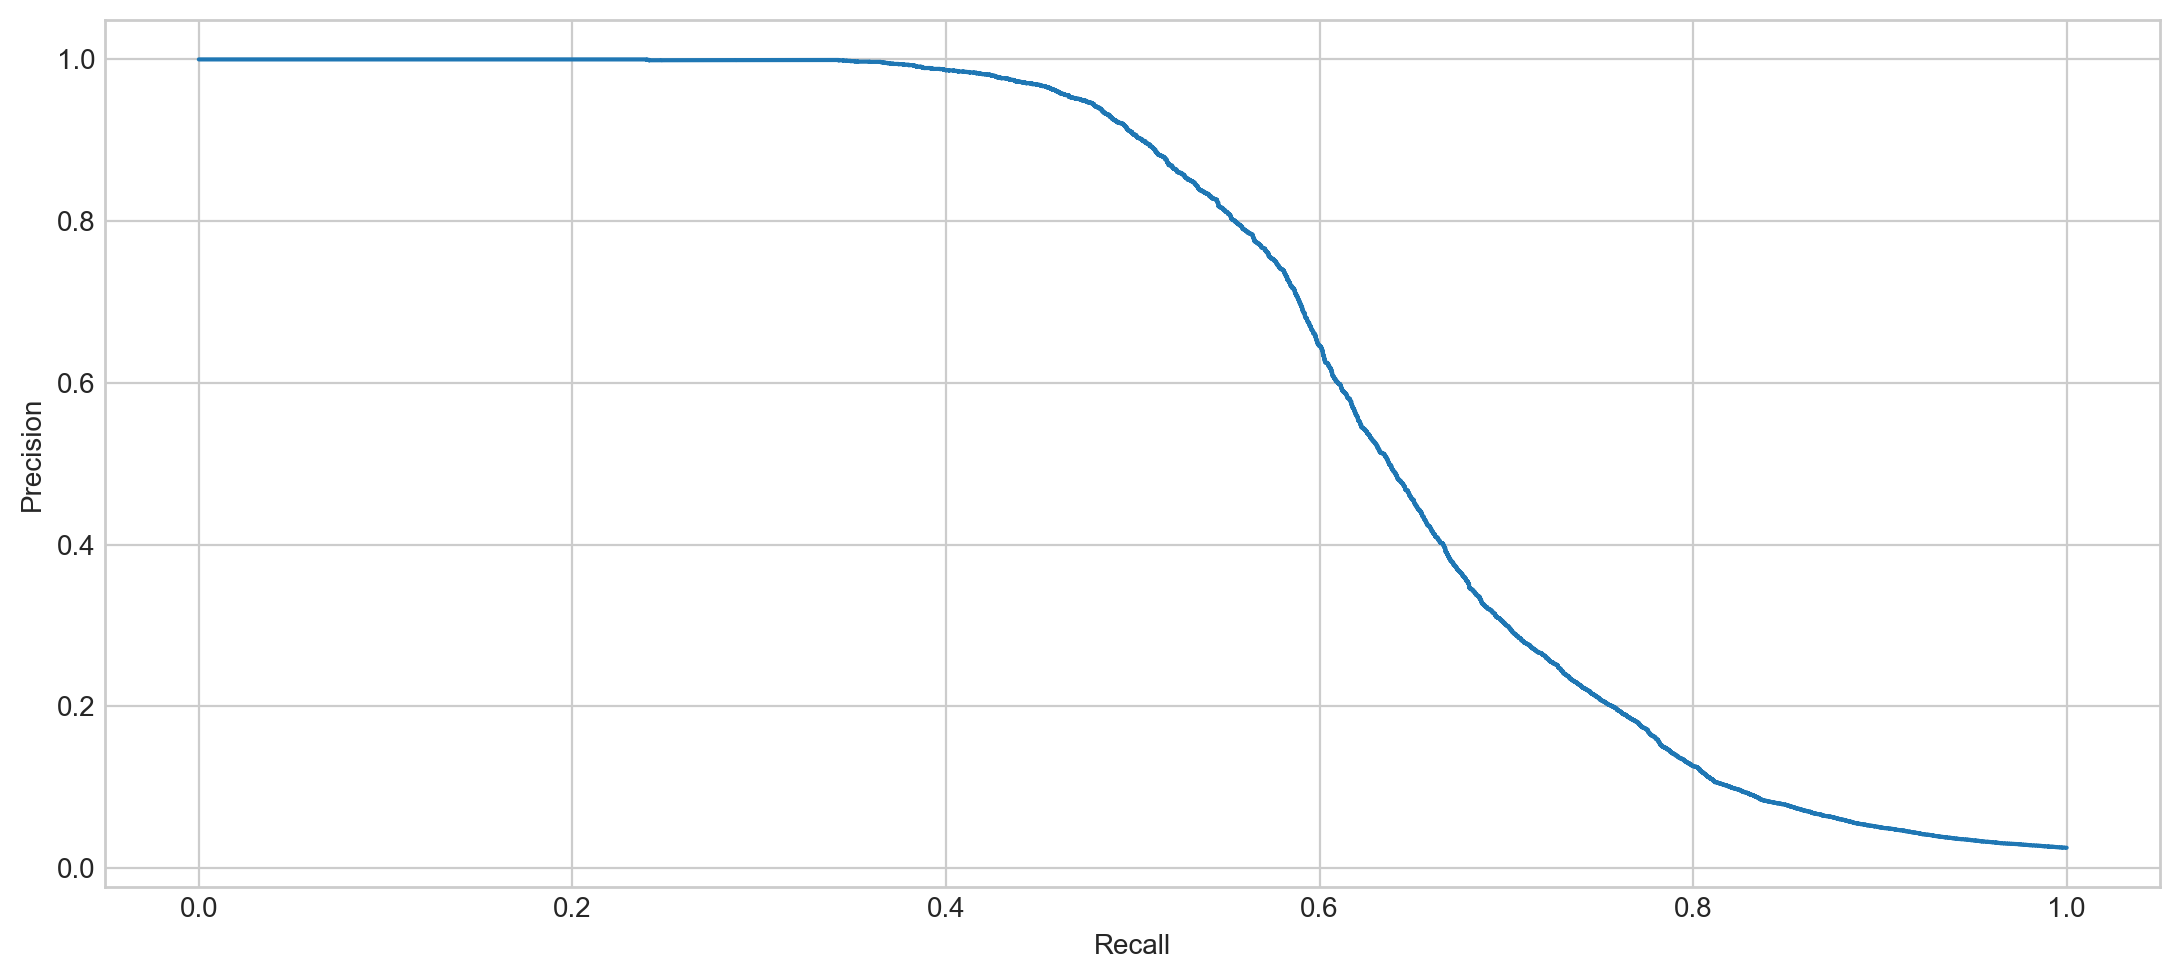

In [20]:
prec, recall, _ = precision_recall_curve(y_val, val_res, pos_label=xgboost.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [21]:
var_ratio = []
for num in np.arange(1,30,2):
  pca = PCA(n_components=num)
  pca.fit(X_train)
  print(np.sum(pca.explained_variance_ratio_))
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

0.5459043316386032
0.7912947627326238
0.8305734297328159
0.863939965439221
0.8900871406382668
0.9073388643177517
0.9207304674317168
0.9306702866577338
0.9400565844861727
0.9480466754197986
0.954954249309223
0.9610601565661088
0.9667199867923326
0.9718466750240374
0.9764162926785791


Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

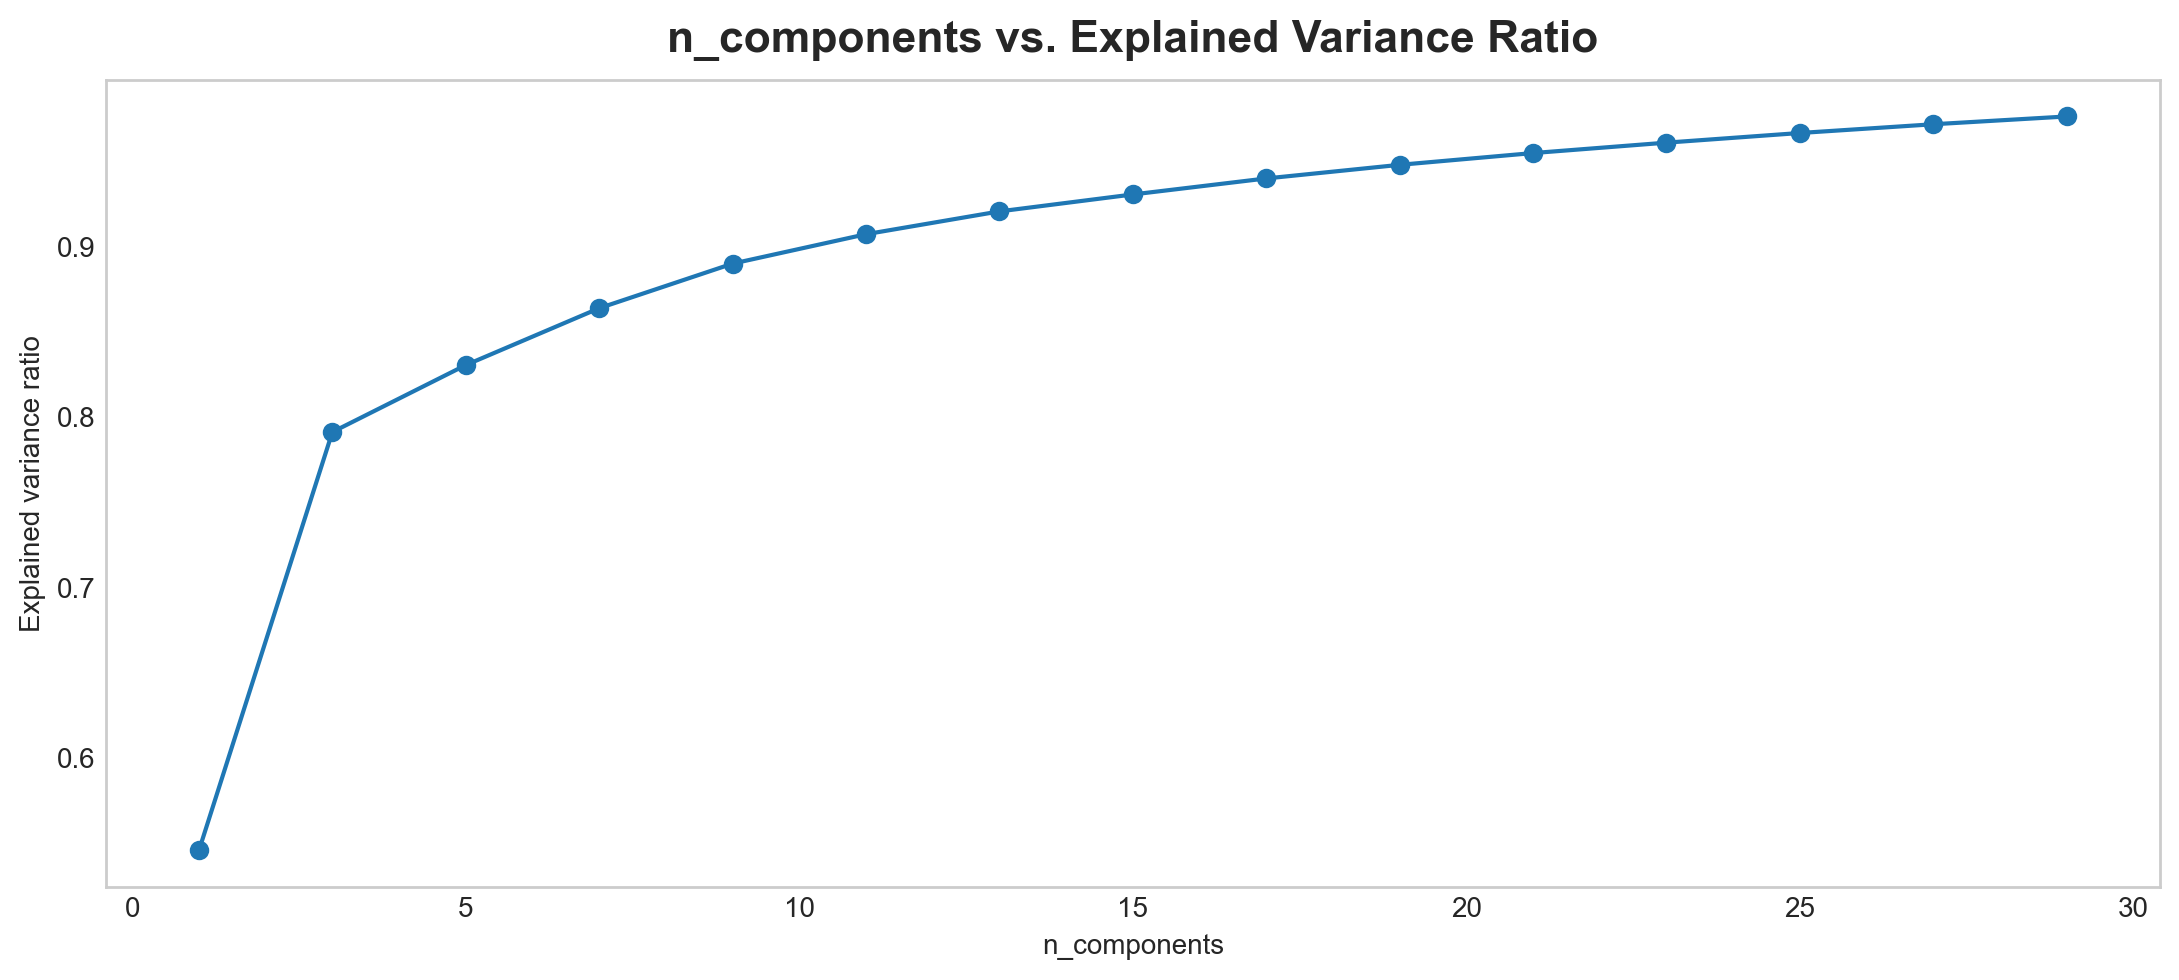

In [23]:
# plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(np.arange(1,30,2),var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [24]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = pca.feature_names_in_
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [25]:
most_important_names

['Month',
 'Day_of_week',
 'CARD_BRAND_Visa',
 'CARD_COUNTRY_CODE_US',
 'ACQUIRER_ID_ACQ2',
 'CARDHOLDER_AUTH_METHOD_Online PIN',
 'TRANSACTION_CURRENCY_GBP',
 'ACQUIRER_ID_ACQ1',
 'TRANSACTION_CURRENCY_USD',
 'CARDHOLDER_AUTH_METHOD_Offline plaintext PIN',
 'TRANSACTION_STATUS_Settled',
 'TRANSACTION_TYPE_Purchase',
 'ACQUIRER_ID_ACQ4',
 'CARDHOLDER_AUTH_METHOD_No CVM performed',
 'TRANSACTION_CURRENCY_CAD',
 'IS_RECURRING_TRANSACTION',
 'CARDHOLDER_AUTH_METHOD_Offline enciphered PIN',
 'CARD_BRAND_Discover',
 'TRANSACTION_CURRENCY_CHF',
 'CARD_COUNTRY_CODE_BE',
 'TRANSACTION_CURRENCY_AED',
 'CARDHOLDER_AUTH_METHOD_Offline plaintext PIN and signature',
 'FAILURE_REASON_0',
 'CARD_COUNTRY_CODE_FR',
 'CARD_COUNTRY_CODE_HR',
 'CARD_COUNTRY_CODE_GB',
 'TRANSACTION_TYPE_Purchase\xa0with\xa0cashback',
 'CARD_COUNTRY_CODE_CA',
 'CARD_COUNTRY_CODE_NO']